In [1]:
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

# Grad-Shafranov FEM solver

This file presents a FEM solver for Grad-Shafranov as a boundary-value problem.
The function GradShafranov takes as input the function G and returns the solution of the problem.
The Mesh, the function space and the (x,y) coordinates must be defined before calling the function.

The default boundary conditions are Homogeneous Dirichlet. These are adopted unless the user specifies otherwise.
The default coordinates adopted are toroidal coordinates (R,z). The user can switch to Cartesian coordinates by specifying "Cartesian = True", but remark that the aspect ratio "eps" must be defined.

In [15]:
def GradShafranov(G, V, Cartesian = False, bc = None, initial_guess = None):

  x,y = SpatialCoordinate(V.mesh())

  if bc is None:
    bc = DirichletBC(V, 0.0, 'on_boundary')

  # Define trial and test functions:
  psi = Function(V, name="Flux Function")
  phi = TestFunction(V)

  # Define the variational problem:
  if (Cartesian == False):
    L  = (dot(grad(psi), grad(phi)) + (1/x) * Dx(psi, 0) * phi) * dx - (G(x,psi) * phi) * dx # for toroidal coordinates
    #L  = 1/x * dot(grad(psi), grad(phi)) * dx - (G(x,psi) * phi) * dx # for toroidal coordinates
  else:
    L = dot(grad(psi), grad(phi))/(1 + eps*x) * dx - r0**2 / (1 + eps*x) * G(x,psi) * phi * dx # for Cartesian nondimensional coordinates

  # Customize initial guess:
  if initial_guess is not None:
    # Create the initial guess based on the provided function:
    psi.interpolate(initial_guess(x,y))

  # Solve with Newton's iterative method:
  solve(L == 0, psi, bcs=bc,
        solver_parameters={'snes_type': 'newtonls',
                          'snes_monitor': None,
                          'ksp_type': 'preonly',
                          'pc_type': 'lu'}
        )

  return psi

## Benchmarking with exact solutions:

### 1. Solov'ev equilibrium in toroidal coordinates:

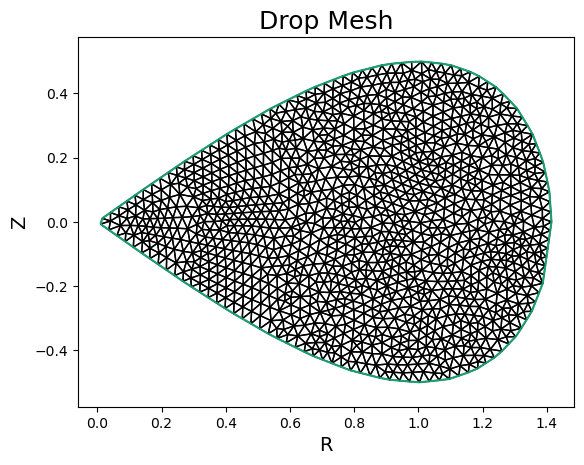

In [3]:
# Import Mesh:
mesh = Mesh(r"meshes/drop/drop_1.msh")

# Plot it
fig, ax = plt.subplots()
triplot(mesh, axes=ax)
plt.title(r"Drop Mesh", fontsize=18)
plt.xlabel("R", fontsize=14)
plt.ylabel("Z", fontsize=14)
ax.axis('equal')

# Define Function Space
V = FunctionSpace(mesh, 'P', 1)
x,y = SpatialCoordinate(mesh) # R = x, z = y.

  0 SNES Function norm 7.281845389804e-02
  1 SNES Function norm 2.644193236234e-15


(-0.060089154387742975,
 1.4844184536474205,
 -0.5495998254704841,
 0.5489357914973014)

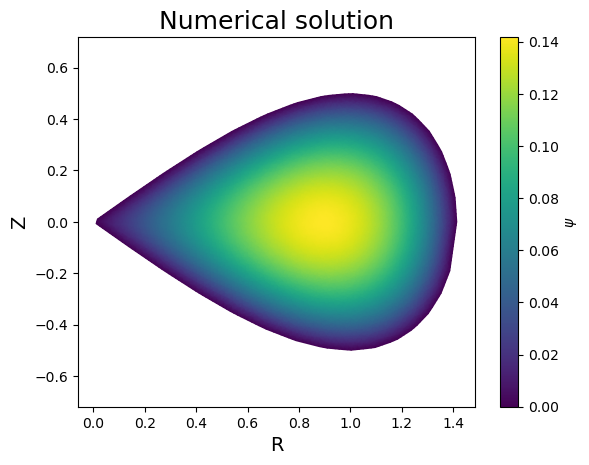

In [4]:
# Solov'ev equilibrium with G1 = 1, G2 = 1:
def G(x,psi):
  return x + 1/x

# Numerical solution:
psi = GradShafranov(G,V)

# Plot:
fig,ax = plt.subplots()
q = tripcolor(psi, axes=ax)
fig.colorbar(q, label = r'$\psi$')
plt.title("Numerical solution", fontsize=18)
plt.xlabel("R", fontsize=14)
plt.ylabel("Z", fontsize=14)
ax.axis('equal')

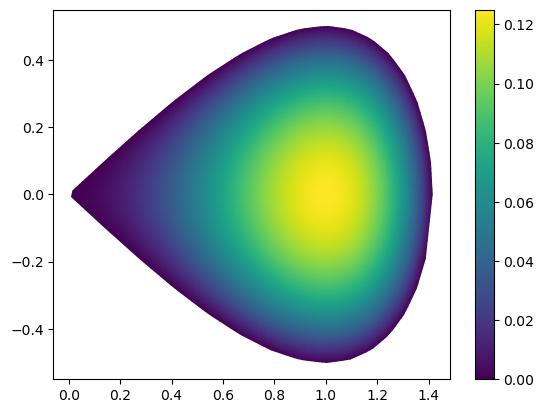

In [5]:
# Exact Solution (in toroidal coordinates):
psi_exact_fun = lambda x,y: ( 1 - (2*y)**2 - (2*(x-1) + (x-1)**2)**2 ) / 8
psi_exact = Function(V)
psi_exact.interpolate(psi_exact_fun(x,y))

# Plot:
fig, ax = plt.subplots()
q = tripcolor(psi_exact, axes=ax)
fig.colorbar(q)

  0 SNES Function norm 7.281845389804e-02
  1 SNES Function norm 1.557893839188e-03
  2 SNES Function norm 7.639002368240e-05
  3 SNES Function norm 3.674550215792e-06
  4 SNES Function norm 1.742445252074e-07
  5 SNES Function norm 8.221713945889e-09
  0 SNES Function norm 3.844958944208e-02
  1 SNES Function norm 7.237759235325e-04
  2 SNES Function norm 3.543430175433e-05
  3 SNES Function norm 1.663686070737e-06
  4 SNES Function norm 7.707858526809e-08
  0 SNES Function norm 2.058032023017e-02
  1 SNES Function norm 3.627230320610e-04
  2 SNES Function norm 1.773222401676e-05
  3 SNES Function norm 8.313749332275e-07
  0 SNES Function norm 1.096738499842e-02
  1 SNES Function norm 3.289602193381e-04
  2 SNES Function norm 2.687095880007e-05
  3 SNES Function norm 2.106887155083e-06


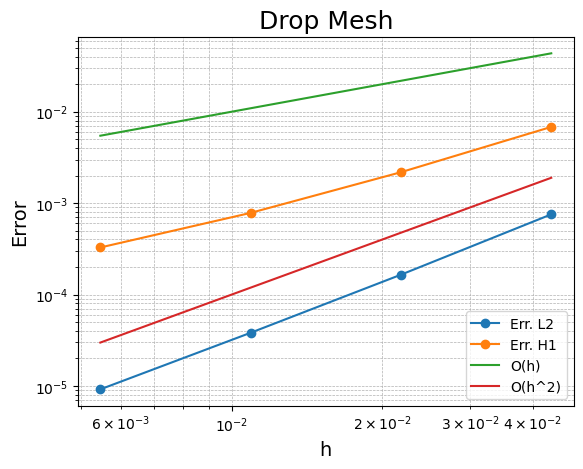

In [ ]:
# Error convergence study:
mesh_files = np.array(("drop_1.msh", "drop_2.msh", "drop_3.msh", "drop_4.msh"))
#h_vec = np.array((1/32,1/64,1/128,1/256))
h_vec = np.zeros((4,1))
err_L2 = np.zeros(h_vec.shape[0])
err_H1 = np.zeros(h_vec.shape[0])

for ii in range(h_vec.shape[0]):
  # Import Mesh:
  mesh_name = mesh_files[ii]
  mesh = Mesh(r"meshes/drop/" + mesh_name)
  V = FunctionSpace(mesh, 'P', 1)
  x,y = SpatialCoordinate(mesh)

  # Numerical solution:
  psi = GradShafranov(G,V)

  # Exact solution:
  psi_exact = Function(V)
  psi_exact.interpolate(psi_exact_fun(x,y))

  # Errors:
  err_L2[ii] =  errornorm(psi_exact, psi, 'L2')
  err_H1[ii] = errornorm(psi_exact, psi, 'H1')

  V0 = FunctionSpace(mesh, "DG", 0)
  h_func = Function(V0).interpolate(CellSize(mesh))
  h_vec[ii] = np.max(h_func.dat.data_ro[:])

# Plot L2/H1 error against n:
plt.loglog(h_vec, err_L2, marker='o', label='Err. L2')
plt.loglog(h_vec, err_H1, marker='o', label='Err. H1')
plt.loglog(h_vec, h_vec, label='O(h)')
plt.loglog(h_vec, h_vec**2, label='O(h^2)')
plt.xlabel('h', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title("Drop Mesh", fontsize=18)
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

### 2. Solov'ev equilibrium in Cartesian coordinates:

In [14]:
# Define parameters for the D-shape:
R0 = 5/3          # major radius
r0 = 1/2          # minor radius
tau = 0           # triangularity
eps = r0 / R0     # aspect ratio
b = 1 - eps       # elongation

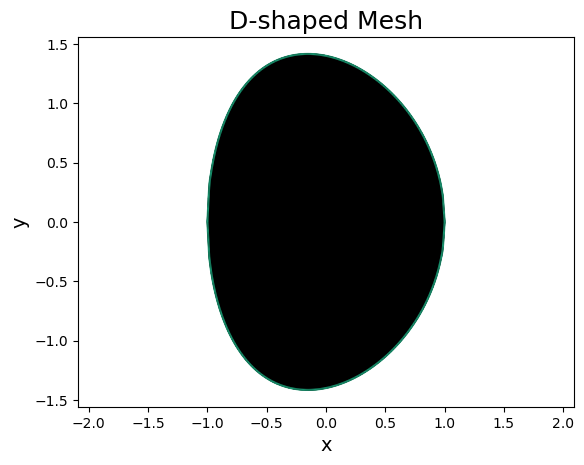

In [15]:
# Import Mesh:
mesh = Mesh(r"meshes/D_mesh/D_mesh_3.msh")

# The mesh above depends on the parameters defined --> for the moment they are defined as well with the same values in the .geo file.

# Plot it
fig, ax = plt.subplots()
triplot(mesh, axes=ax)
plt.title(r"D-shaped Mesh", fontsize=18)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
ax.axis('equal')

# Define Function Space
V = FunctionSpace(mesh, 'P', 1)
x,y = SpatialCoordinate(mesh) # R = x, z = y.

  0 SNES Function norm 4.515547056236e-02
  1 SNES Function norm 1.790331202592e-07
  2 SNES Function norm 1.246141822209e-13


(-1.1, 1.1, -1.5576210841598397, 1.5576181782820526)

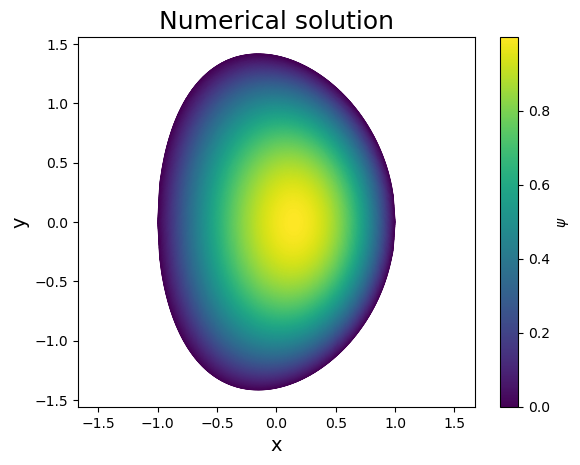

In [17]:
# G1(psi) = alpha = costant, G2(psi) = beta = constant:
alpha = ( 4*(r0**2+b**2)*eps + r0**2 * (2*tau - eps**3) ) / ( 2*R0**2 * eps * r0**2 * b**2)
beta = - tau / (eps * b**2)

# Define G1 and G2 as functions of cartesian coordinates
# Solver uses toroidal coordinates, the input variables
def G(x,psi):
  return alpha * (R0 * (1+eps*x))**2 + beta

# Numerical solution:
psi = GradShafranov(G, V, Cartesian = True)

# Plot:
fig,ax = plt.subplots()
q = tripcolor(psi, axes=ax)
fig.colorbar(q, label = r'$\psi$')
plt.title("Numerical solution", fontsize=18)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
ax.axis('equal')

(-1.1, 1.1, -1.5576210841598397, 1.5576181782820526)

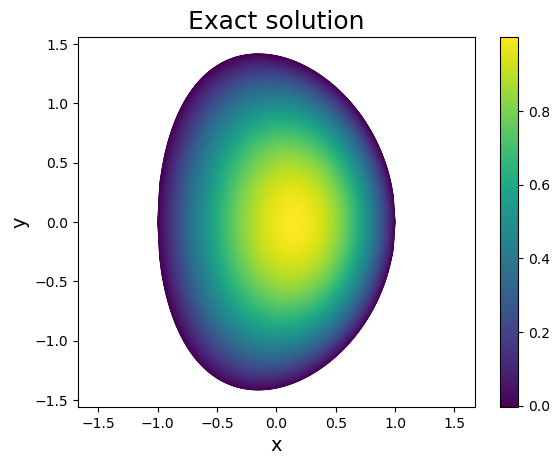

In [19]:
# Exact Solution (in cartesian coord):
psi_exact_fun = lambda x,y: 1-(x-eps/2*(1-x**2))**2-((1-eps**2/4)*(1+eps*x)**2+tau*x*(1+eps/2*x))*(r0/b*y)**2
psi_exact = Function(V)
psi_exact.interpolate(psi_exact_fun(x,y))

# Plot:
fig, ax = plt.subplots()
q = tripcolor(psi_exact, axes=ax)
fig.colorbar(q)
plt.title("Exact solution", fontsize=18)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
ax.axis('equal')

  0 SNES Function norm 3.530688110499e-01
  1 SNES Function norm 1.319662854571e-05
  2 SNES Function norm 5.338839862306e-10
  0 SNES Function norm 1.759768499362e-01
  1 SNES Function norm 2.928281028896e-06
  2 SNES Function norm 3.036597266742e-11
  0 SNES Function norm 9.040072769850e-02
  1 SNES Function norm 7.155567212990e-07
  2 SNES Function norm 1.935688162348e-12
  0 SNES Function norm 4.515547056236e-02
  1 SNES Function norm 1.790331202592e-07
  2 SNES Function norm 1.246141822209e-13


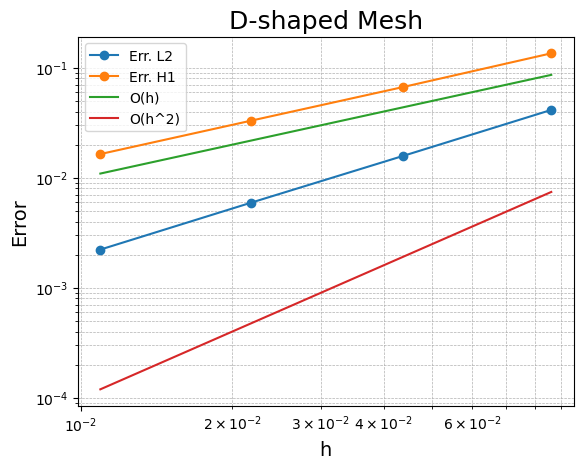

In [30]:
mesh_files = np.array(("D_mesh_4.msh", "D_mesh_1.msh", "D_mesh_2.msh", "D_mesh_3.msh"))
#h_vec = np.array((1/16,1/32,1/64,1/128))
h_vec = np.zeros((4,1))
err_L2 = np.zeros(h_vec.shape[0])
err_H1 = np.zeros(h_vec.shape[0])

for ii in range(h_vec.shape[0]):
  # Import Mesh:
  mesh_name = mesh_files[ii]
  mesh = Mesh(r"meshes/D_mesh/" + mesh_name)
  V = FunctionSpace(mesh, 'P', 1)
  x,y = SpatialCoordinate(mesh)

  # Numerical solution:
  psi = GradShafranov(G, V, Cartesian = True)

  # Exact solution:
  psi_exact = Function(V)
  psi_exact.interpolate(psi_exact_fun(x,y))

  # Errors:
  err_L2[ii] =  errornorm(psi_exact, psi, 'L2')
  err_H1[ii] = errornorm(psi_exact, psi, 'H1')

  V0 = FunctionSpace(mesh, "DG", 0)
  h_func = Function(V0).interpolate(CellSize(mesh))
  h_vec[ii] = np.max(h_func.dat.data_ro[:])

# L2/H1 error against n:
plt.loglog(h_vec, err_L2, marker='o', label='Err. L2')
plt.loglog(h_vec, err_H1, marker='o', label='Err. H1')
plt.loglog(h_vec, h_vec, label='O(h)')
plt.loglog(h_vec, h_vec**2, label='O(h^2)') # "*10" to better visually compare slopes
plt.xlabel('h', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title("D-shaped Mesh", fontsize=18)
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

### 3. Linear poloidal J on elliptic domain:

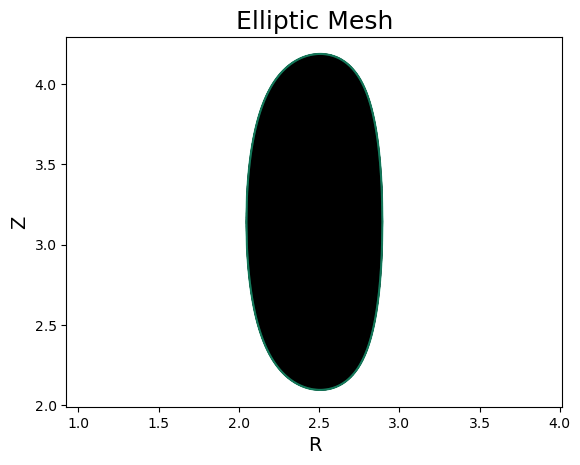

In [3]:
# Import Mesh:
mesh = Mesh(r"meshes/elliptic/elliptic_4.msh")

# Plot it
fig, ax = plt.subplots()
triplot(mesh, axes=ax)
plt.title("Elliptic Mesh", fontsize=18)
plt.xlabel("R", fontsize=14)
plt.ylabel("Z", fontsize=14)
ax.axis('equal')

# Define Function Space
V = FunctionSpace(mesh, 'P', 1)
x,y = SpatialCoordinate(mesh) # R = x, z = y.

Remark: the boundary conditions here are non-physical as the flux is lifted by "0.5". This is necessary as with homogeneous Dirichlet conditions the solution is the trivial one (psi=0 makes GS 0=0). The idea is to downlift back the numerical solution to enforce zero flux at the boundary. This is non-necessary here as this simulation is just needed to test the solver.

  0 SNES Function norm 9.203513223986e+00
  1 SNES Function norm 2.565712775755e-13


(2.004265835775972, 2.936792598350075, 1.989677681125574, 4.293507626053798)

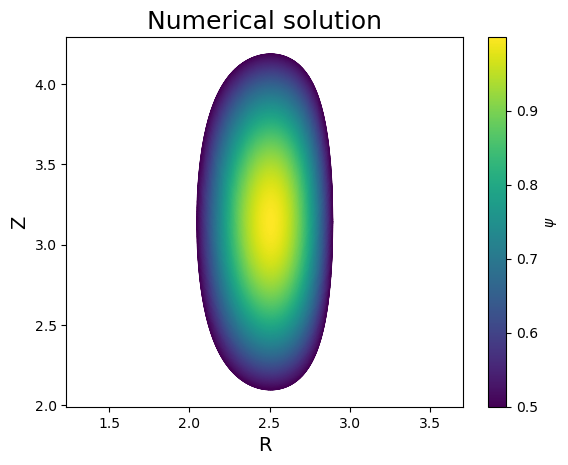

In [4]:
# G1 = psi, G2 = psi
def G(x,psi):
  return (x + 1/x) * psi

# Numerical solution:
#psi = GradShafranov(G, Cartesian = False, bc = DirichletBC(V, 0.0, 'on_boundary'))
psi = GradShafranov(G, V, Cartesian = False, bc = DirichletBC(V, 0.5, 'on_boundary'))

# Plot:
fig,ax = plt.subplots()
q = tripcolor(psi, axes=ax)
fig.colorbar(q, label = r'$\psi$')
plt.title("Numerical solution", fontsize=18)
plt.xlabel("R", fontsize=14)
plt.ylabel("Z", fontsize=14)
ax.axis('equal')

(2.004265835775972, 2.936792598350075, 1.989677681125574, 4.293507626053798)

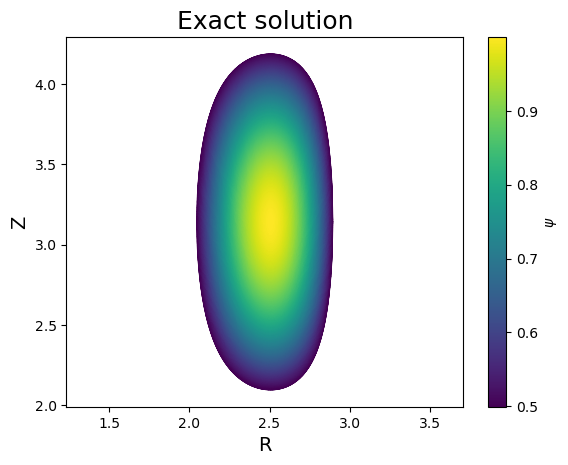

In [9]:
# Exact Solution:
psi_exact_fun = lambda x,y: cos(x**2 / 2)*cos(y) #- 0.5
psi_exact = Function(V)
psi_exact.interpolate(psi_exact_fun(x,y))

# Plot:
fig, ax = plt.subplots()
q = tripcolor(psi_exact, axes=ax)
fig.colorbar(q, label = r'$\psi$')
plt.title("Exact solution", fontsize=18)
plt.xlabel("R", fontsize=14)
plt.ylabel("Z", fontsize=14)
ax.axis('equal')

  0 SNES Function norm 3.208734510887e+00
  1 SNES Function norm 5.836383333321e-13
  0 SNES Function norm 4.642190369184e+00
  1 SNES Function norm 2.968292094966e-14
  0 SNES Function norm 6.516088747880e+00
  1 SNES Function norm 6.858427400247e-14
  0 SNES Function norm 9.203513223986e+00
  1 SNES Function norm 2.565712775755e-13


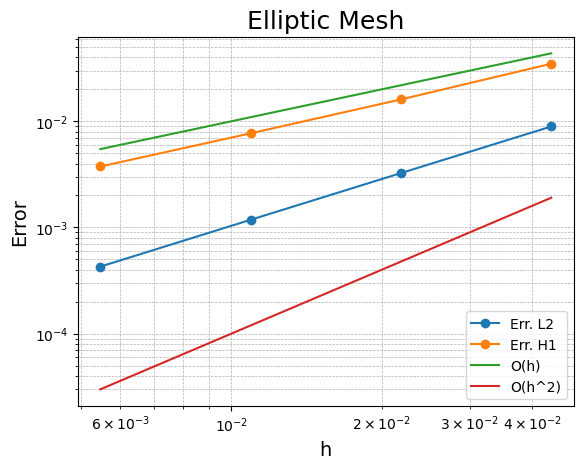

In [8]:
mesh_files = np.array(("elliptic_1.msh", "elliptic_2.msh", "elliptic_3.msh", "elliptic_4.msh"))
#h_vec = np.array(mesh_files.shape[0])
h_vec = np.zeros(mesh_files.shape[0])
err_L2 = np.zeros(h_vec.shape[0])
err_H1 = np.zeros(h_vec.shape[0])

for ii in range(h_vec.shape[0]):
  mesh_name = mesh_files[ii]
  mesh = Mesh(r"meshes/elliptic/" + mesh_name)
  V = FunctionSpace(mesh, 'P', 1)
  x,y = SpatialCoordinate(mesh)

  psi = GradShafranov(G, V, Cartesian = False, bc = DirichletBC(V, 0.5, 'on_boundary'))
  psi_exact = Function(V)
  psi_exact.interpolate(psi_exact_fun(x,y))

  err_L2[ii] =  errornorm(psi_exact, psi, 'L2')
  err_H1[ii] = errornorm(psi_exact, psi, 'H1')

  V0 = FunctionSpace(mesh, "DG", 0)
  h_func = Function(V0).interpolate(CellSize(mesh))
  h_vec[ii] = np.max(h_func.dat.data_ro[:])

# L2/H1 error against n:
plt.loglog(h_vec, err_L2, marker='o', label='Err. L2')
plt.loglog(h_vec, err_H1, marker='o', label='Err. H1')
plt.loglog(h_vec, h_vec, label='O(h)')
plt.loglog(h_vec, h_vec**2, label='O(h^2)')
plt.xlabel('h', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title("Elliptic Mesh", fontsize=18)
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

## Benchmarking in the nonlinear case

### 4. Manufactured solution in toroidal coordinates:

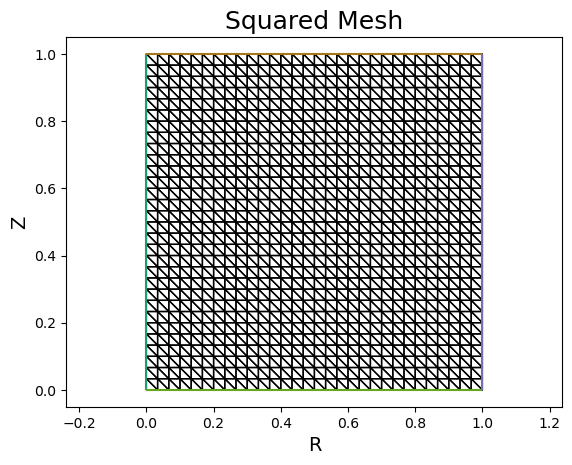

In [10]:
# Import Mesh:
n = 30
mesh = UnitSquareMesh(n, n)

# Plot it
fig, ax = plt.subplots()
triplot(mesh, axes=ax)
plt.title(r"Squared Mesh", fontsize=18)
plt.xlabel("R", fontsize=14)
plt.ylabel("Z", fontsize=14)
ax.axis('equal')

# Define Function Space
V = FunctionSpace(mesh, 'P', 1)
x,y = SpatialCoordinate(mesh) # R = x, z = y.

In [11]:
R, Z = sp.symbols('R z')
psi = sp.Function('psi')(R, Z)

# Manufactured solution s.t. it vanishes on the boundary
#psi_expr = sp.sin(sp.pi * R) * sp.sin(sp.pi * Z)
psi_expr = sp.sin(sp.pi * R) * (sp.exp(sp.sin(sp.pi * Z)) - 1)
print("Manufactured solution:")
display(sp.Eq(psi, psi_expr))

Manufactured solution:


Eq(psi(R, z), (exp(sin(pi*z)) - 1)*sin(pi*R))

(-0.05, 1.05, -0.05, 1.05)

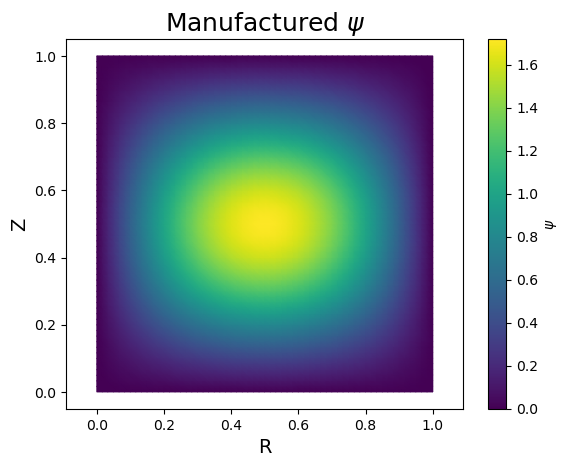

In [12]:
# Plot the manufactured solution:
#psi_exact_fun = lambda R,z: sin(pi * R) * sin(pi * z)
#psi_exact_fun = lambda R,z: sin(pi * R) * sin(pi * z)**3
psi_exact_fun = lambda R,z: sin(pi * R) * (exp(sin(pi * z)) - 1)
psi_exact = Function(V)
psi_exact.interpolate(psi_exact_fun(x,y))

# Plot:
fig, ax = plt.subplots()
q = tripcolor(psi_exact, axes=ax)
fig.colorbar(q, label = r'$\psi$')
plt.title(r"Manufactured $\psi$", fontsize=18)
plt.xlabel("R", fontsize=14)
plt.ylabel("Z", fontsize=14)
ax.axis('equal')

In [13]:
# Compute derivatives
d2psi_dR2 = sp.diff(psi_expr, R, 2)
dpsi_dR = sp.diff(psi_expr, R)
d2psi_dZ2 = sp.diff(psi_expr, Z, 2)

# Plug psi into Grad-Shafranov operator
delta_star_psi = (1/R) * d2psi_dZ2 + (1/R) * d2psi_dR2 - (1/R**2) * dpsi_dR

# Define and display G(R,z) 
G_expr = -delta_star_psi
G = sp.Function('G')(R, Z)
display(sp.Eq(G, G_expr))

Eq(G(R, z), pi**2*(exp(sin(pi*z)) - 1)*sin(pi*R)/R + pi**2*(sin(pi*z) - cos(pi*z)**2)*exp(sin(pi*z))*sin(pi*R)/R + pi*(exp(sin(pi*z)) - 1)*cos(pi*R)/R**2)

Now perform the substitution of z = z(\psi,R) into G(R,z) to obtain finally the manufactured expression of G(R,\psi):

  0 SNES Function norm 2.222958741335e-01
  1 SNES Function norm 1.322668099102e-01
  2 SNES Function norm 1.028248465073e-02
  3 SNES Function norm 1.335692393154e-04
  4 SNES Function norm 1.980383684299e-06
  5 SNES Function norm 6.303456223604e-11


(-0.05, 1.05, -0.05, 1.05)

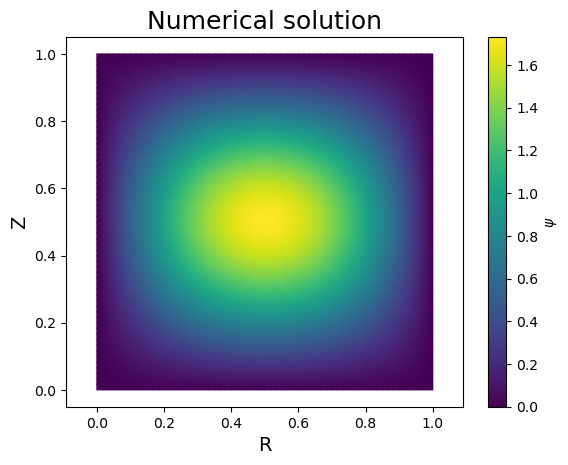

In [16]:
def G(R,psi):
  #return (2 * pi**2 + (pi/R) * cos(pi * R) / sin(pi * R)) * (psi-1.0)
  #return np.pi * ( 10.0 * pi + (1/x) * cos(pi * x) / sin(pi * x) ) * psi - 6.0 * pi**2 * sin(pi * x)**(2/3) * psi**(1/3)
  return ( (pi + cos(pi*R)/sin(pi*R)/R)*pi*psi + pi**2 * ( ln(1+psi/sin(pi*R)) + ln(1+psi/sin(pi*R))**2 -1 ) * ( psi + sin(pi*R) ) )

# Numerical solution:
def psi0(R,z):
  return sin(pi * R) * sin(pi*z)
psi = GradShafranov(G, V, Cartesian = False, bc = None, initial_guess=psi0)

# Plot:
fig, ax = plt.subplots()
q = tripcolor(psi, axes=ax)
fig.colorbar(q, label = r'$\psi$')
plt.title("Numerical solution", fontsize=18)
plt.xlabel("R", fontsize=14)
plt.ylabel("Z", fontsize=14)
ax.axis('equal')

  0 SNES Function norm 4.127795134755e-01
  1 SNES Function norm 2.656203338901e-01
  2 SNES Function norm 2.333863206188e-02
  3 SNES Function norm 7.580507197555e-04
  4 SNES Function norm 1.026278586479e-05
  5 SNES Function norm 6.734121741077e-10
  0 SNES Function norm 2.085766799092e-01
  1 SNES Function norm 1.235784416778e-01
  2 SNES Function norm 9.549119033356e-03
  3 SNES Function norm 1.164221533925e-04
  4 SNES Function norm 1.619314989326e-06
  5 SNES Function norm 4.656993239823e-11
  0 SNES Function norm 1.049993654789e-01
  1 SNES Function norm 6.062658223180e-02
  2 SNES Function norm 4.525529490232e-03
  3 SNES Function norm 3.791429632842e-05
  4 SNES Function norm 1.459769574792e-07
  5 SNES Function norm 1.244634080956e-12
  0 SNES Function norm 5.269508316537e-02
  1 SNES Function norm 3.016127333208e-02
  2 SNES Function norm 2.229307452751e-03
  3 SNES Function norm 1.852438124019e-05
  4 SNES Function norm 1.212134007387e-08
  5 SNES Function norm 3.798713034

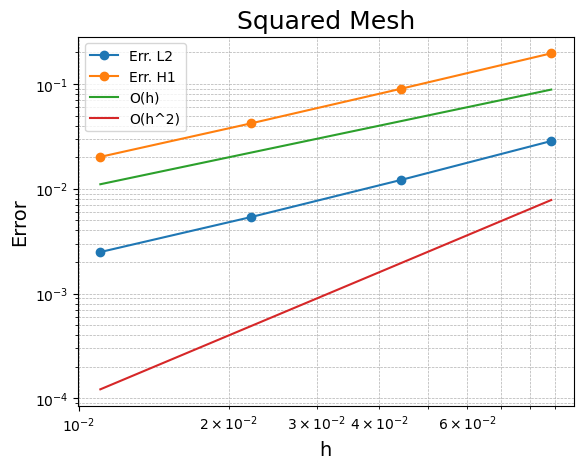

In [20]:
# Verify the convergence:
n_vec = np.array((16,32,64,128))
#h_vec = np.zeros(n_vec.shape[0])
err_L2 = np.zeros(n_vec.shape[0])
err_H1 = np.zeros(n_vec.shape[0])

for ii in range(n_vec.shape[0]):
  n = n_vec[ii]
  mesh = UnitSquareMesh(n, n)
  V = FunctionSpace(mesh, 'P', 1)
  x,y = SpatialCoordinate(mesh)

  psi = GradShafranov(G, V, initial_guess=psi0)
  psi_exact = Function(V)
  psi_exact.interpolate(psi_exact_fun(x,y))

  err_L2[ii] =  errornorm(psi_exact, psi, 'L2')
  err_H1[ii] = errornorm(psi_exact, psi, 'H1')
  '''
  V0 = FunctionSpace(mesh, "DG", 0)
  h_func = Function(V0).interpolate(CellSize(mesh))
  h_vec[ii] = np.max(h_func.dat.data_ro[:])
  '''
# L2/H1 error against n:
h_vec = np.sqrt(2)*(1./n_vec)
plt.loglog(h_vec, err_L2, marker='o', label='Err. L2')
plt.loglog(h_vec, err_H1, marker='o', label='Err. H1')
plt.loglog(h_vec, h_vec, label='O(h)')
plt.loglog(h_vec, h_vec**2, label='O(h^2)')
plt.xlabel('h', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title("Squared Mesh", fontsize=18)
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

### 5. Manufactured solution in Cartesian coordinates:

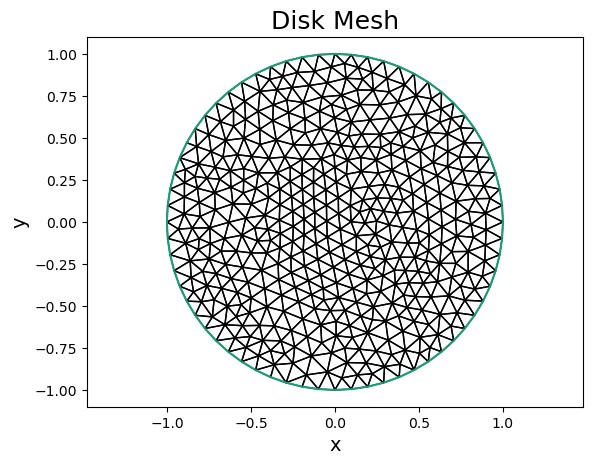

In [ ]:
# Define parameters for the circular cross-section:
R0 = 4           # torus radius
r0 = 1           # disk radius (cross-section)
eps = r0 / R0    # aspect ratio

# Build circular mesh:
#n = 4
#mesh = UnitDiskMesh(n)
mesh = Mesh(r"meshes/disk/disk_5.msh")

# Plot it
fig, ax = plt.subplots()
triplot(mesh, axes=ax)
plt.title(r"Disk Mesh", fontsize=18)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
ax.axis('equal')

# Define Function Space
V = FunctionSpace(mesh, 'P', 1)
x,y = SpatialCoordinate(mesh)   # R = R0 + x*r0 , z = y*r0

In [53]:
symx, symy, symeps = sp.symbols('x y epsilon')
psi = sp.Function('psi')(symx, symy)

# Manufactured solution s.t. it vanishes on the boundary
#psi_expr = 1 - symx**2 - symy**2
#psi_expr = sp.cos( sp.pi / 2 * (symx**2 + symy**2) ) --> solutore diverge subito
#psi_expr = sp.sin(sp.pi * (1 - symx**2 - symy**2) ) --> solutore propone soluzione negativa: non riconosce la forma "a ciambella"
psi_expr = sp.exp( 1 - symx**2 - symy**2 ) - 1
print("Manufactured solution:")
display(sp.Eq(psi, psi_expr))

Manufactured solution:


Eq(psi(x, y), exp(-x**2 - y**2 + 1) - 1)

(-1.1, 1.1, -1.1, 1.1)

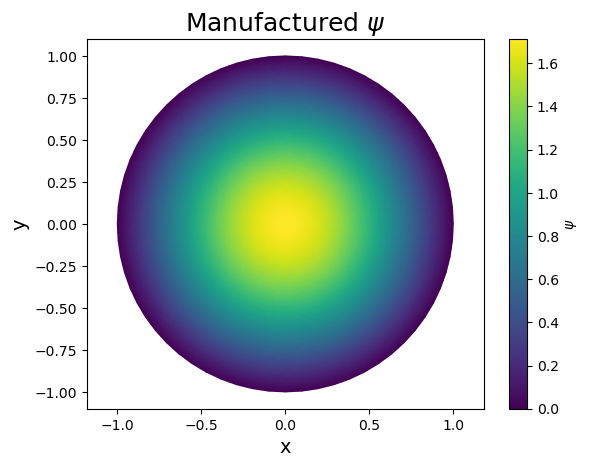

In [59]:
# Plot the manufactured solution:
#psi_exact_fun = lambda x,y: 1 - x**2 - y**2
#psi_exact_fun = lambda x,y: cos( pi / 2 * (x**2 + y**2) )
#psi_exact_fun = lambda x,y: sin( pi * (1 - x**2 - y**2) )
psi_exact_fun = lambda x,y: exp( 1 - x**2 - y**2) - 1
psi_exact = Function(V)
psi_exact.interpolate(psi_exact_fun(x,y))

# Plot:
fig, ax = plt.subplots()
q = tripcolor(psi_exact, axes=ax)
fig.colorbar(q, label = r'$\psi$')
plt.title(r"Manufactured $\psi$", fontsize=18)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
ax.axis('equal')

In [55]:
# Compute derivatives
d2psi_dx2 = sp.diff(psi_expr, symx, 2)
dpsi_dx = sp.diff(psi_expr, symx)
d2psi_dy2 = sp.diff(psi_expr, symy, 2)

# Plug psi into Grad-Shafranov operator
delta_star_psi = (d2psi_dx2 - eps/(1+eps*symx)*dpsi_dx + d2psi_dy2) / r0**2

# Define and display G(x,y) 
G_expr = -delta_star_psi
G = sp.Function('G')(symx, symy)
display(sp.Eq(G, G_expr))

Eq(G(x, y), -0.5*x*exp(-x**2 - y**2 + 1)/(0.25*x + 1) - 2*(2*x**2 - 1)*exp(-x**2 - y**2 + 1) - 2*(2*y**2 - 1)*exp(-x**2 - y**2 + 1))

  0 SNES Function norm 3.019099447818e-01
  1 SNES Function norm 8.924979272660e-02
  2 SNES Function norm 1.230371301583e-02
  3 SNES Function norm 5.460440567495e-04
  4 SNES Function norm 1.320303284995e-06
  5 SNES Function norm 7.806836959652e-12


(-1.1, 1.1, -1.1, 1.1)

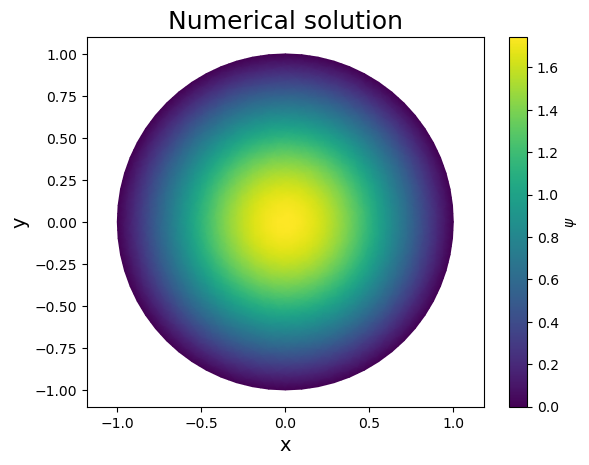

In [60]:
def G(x,psi):
  #return - 4*pi/(x+4) * sqrt(1-psi**2) + 2 * pi * acos(psi) * psi
  #return - pi/2*x*sqrt(1-psi**2)/(x/4+1) - 4*pi*sqrt(1-psi**2) - 4*pi*(1 - asin(psi)/pi) * psi
  return ( 1 + psi ) * ( 4 * ln(1 + psi) - 2*x/(x+4))

# Numerical solution: 
psi0 = lambda x,y: 1 - x**2 - y**2
psi = GradShafranov(G, V, Cartesian=True, initial_guess=psi0)
#psi = GradShafranov(G, Cartesian=True)   --> partendo da guess = 0, il solver trova una soluzione negativa molto piccola

# Plot:
fig, ax = plt.subplots()
q = tripcolor(psi, axes=ax)
fig.colorbar(q, label = r'$\psi$')
plt.title("Numerical solution", fontsize=18)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
ax.axis('equal')

  0 SNES Function norm 5.485881333993e-01
  1 SNES Function norm 5.137166522697e-01
  2 SNES Function norm 8.573078760700e-02
  3 SNES Function norm 7.227040675872e-03
  4 SNES Function norm 7.791460021152e-05
  5 SNES Function norm 9.508373027342e-09
  6 SNES Function norm 1.664886339727e-15
  0 SNES Function norm 3.545402873378e-01
  1 SNES Function norm 1.279195204070e-01
  2 SNES Function norm 1.786964464118e-02
  3 SNES Function norm 8.517468576339e-04
  4 SNES Function norm 2.402269596696e-06
  5 SNES Function norm 1.936199237252e-11
  0 SNES Function norm 1.998161344961e-01
  1 SNES Function norm 5.394802680227e-02
  2 SNES Function norm 7.081618907808e-03
  3 SNES Function norm 2.837150280870e-04
  4 SNES Function norm 5.435128497736e-07
  5 SNES Function norm 2.013266578464e-12
  0 SNES Function norm 1.058293933319e-01
  1 SNES Function norm 2.587353620756e-02
  2 SNES Function norm 3.337894763927e-03
  3 SNES Function norm 1.277363640048e-04
  4 SNES Function norm 2.211778035

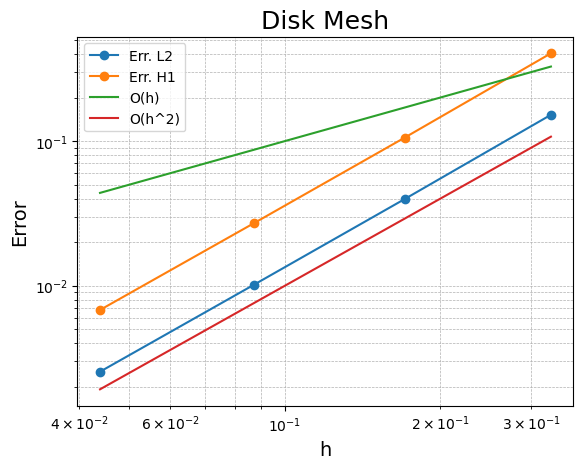

In [ ]:
# Verify the convergence:
n_vec = np.array((2,3,4,5))
h_vec = np.zeros(n_vec.shape[0])
err_L2 = np.zeros(n_vec.shape[0])
err_H1 = np.zeros(n_vec.shape[0])

for ii in range(n_vec.shape[0]):
  n = n_vec[ii]
  mesh = UnitDiskMesh(n)
  V = FunctionSpace(mesh, 'P', 1)
  x,y = SpatialCoordinate(mesh)

  psi = GradShafranov(G, V, Cartesian=True, initial_guess=psi0)
  psi_exact = Function(V)
  psi_exact.interpolate(psi_exact_fun(x,y))

  err_L2[ii] =  errornorm(psi_exact, psi, 'L2')
  err_H1[ii] = errornorm(psi_exact, psi, 'H1')

  V0 = FunctionSpace(mesh, "DG", 0)
  h_func = Function(V0).interpolate(CellSize(mesh))
  #h_vec[ii] = np.mean(h_func.dat.data_ro[:])
  h_vec[ii] = np.max(h_func.dat.data_ro[:])

# L2/H1 error against n:
plt.loglog(h_vec, err_L2, marker='o', label='Err. L2')
plt.loglog(h_vec, err_H1, marker='o', label='Err. H1')
plt.loglog(h_vec, h_vec, label='O(h)')
plt.loglog(h_vec, h_vec**2, label='O(h^2)')
plt.xlabel('h', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title("Disk Mesh", fontsize=18)
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

  0 SNES Function norm 1.637851326359e-01
  1 SNES Function norm 4.099283875139e-02
  2 SNES Function norm 5.349324644697e-03
  3 SNES Function norm 2.103787380635e-04
  4 SNES Function norm 3.870780788751e-07
  5 SNES Function norm 1.322385485140e-12
  0 SNES Function norm 6.989427985236e-02
  1 SNES Function norm 1.626907698046e-02
  2 SNES Function norm 2.095866442183e-03
  3 SNES Function norm 7.950769914666e-05
  4 SNES Function norm 1.351648511679e-07
  5 SNES Function norm 3.942698734585e-13
  0 SNES Function norm 3.579836205563e-02
  1 SNES Function norm 8.156750566426e-03
  2 SNES Function norm 1.046621834921e-03
  3 SNES Function norm 3.950344968159e-05
  4 SNES Function norm 6.637225117257e-08
  5 SNES Function norm 1.917174899817e-13
  0 SNES Function norm 1.797776541172e-02
  1 SNES Function norm 4.069694659581e-03
  2 SNES Function norm 5.237659421495e-04
  3 SNES Function norm 1.972810748414e-05
  4 SNES Function norm 3.304778093101e-08
  5 SNES Function norm 1.133906658

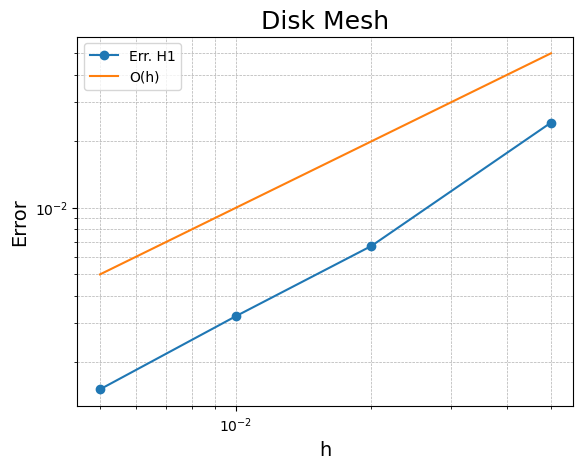

In [66]:
# Error convergence study:
mesh_files = np.array(("disk_2.msh","disk_3.msh", "disk_4.msh", "disk_1.msh"))
h_vec = np.array((0.05,0.02,0.01,0.005))
err_L2 = np.zeros(h_vec.shape[0])
err_H1 = np.zeros(h_vec.shape[0])

for ii in range(h_vec.shape[0]):
  # Import Mesh:
  mesh_name = mesh_files[ii]
  mesh = Mesh(r"Meshes/disk/" + mesh_name)
  V = FunctionSpace(mesh, 'P', 1)
  x,y = SpatialCoordinate(mesh)

  # Numerical solution:
  psi = GradShafranov(G, V, Cartesian=True, initial_guess=psi0)

  # Exact solution:
  psi_exact = Function(V)
  psi_exact.interpolate(psi_exact_fun(x,y))

  # Errors:
  #err_L2[ii] =  errornorm(psi_exact, psi, 'L2')
  err_H1[ii] = errornorm(psi_exact, psi, 'H1')

# Plot L2/H1 error against n:
#plt.loglog(h_vec, err_L2, marker='o', label='Err. L2')
plt.loglog(h_vec, err_H1, marker='o', label='Err. H1')
plt.loglog(h_vec, h_vec, label='O(h)')
#plt.loglog(h_vec, h_vec**2, label='O(h^2)')
plt.xlabel('h', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title("Disk Mesh", fontsize=18)
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)